In [32]:
import os

os.chdir(str(globals()["_dh"][0]).removesuffix("/statistics"))
print(os.getcwd())

import pickle
import matplotlib.pyplot as plt
import gzip
import yaml

from Config import Config

plt.style.use("seaborn-v0_8")


# Load config file
with open("config.yml", "r") as file:
    global config
    config = Config(yaml.safe_load(file.read()))

with gzip.open(filename=config.algorithm.statistics_filename, mode="rb") as f:
    loaded_stats = pickle.load(f)

/home/riccardo/AAS


In [33]:
episode_numbers = []
winners = []
hp_remaining_winner = []
total_rewards = []
actions_number = {}  # {agentName: {action_name: [episode1_count, episode2_count, ...]}}

# Prima passata per trovare tutti gli agenti e le azioni
agents = set()
actions = set()

for stats in loaded_stats.values():
    for actions_list in stats["list"]:
        for agentName, action_stat in actions_list.items():
            agents.add(agentName)
            actions.update(action_stat.keys())

# Inizializzazione del dizionario
for agentName in agents:
    actions_number[agentName] = {actionName: [0] * len(loaded_stats) for actionName in actions}

# Seconda passata per contare le azioni in ogni episodio
for episode_index, (episode_num, stats) in enumerate(loaded_stats.items()):
    episode_numbers.append(episode_num)
    winners.append(stats["winner"])
    hp_remaining_winner.append(stats["hp_remaining_winner"])
    total_rewards.append(stats["total_reward"])

    episode_actions = {agentName: {actionName: 0 for actionName in actions} for agentName in agents}

    for actions_list in stats["list"]:
        for agentName, action_stat in actions_list.items():
            for actionName, actionCount in action_stat.items():
                episode_actions[agentName][actionName] += actionCount

    # Aggiornare il dizionario con i conteggi per l'episodio corrente
    for agentName in agents:
        for actionName in actions:
            actions_number[agentName][actionName][episode_index] = episode_actions[agentName][actionName]

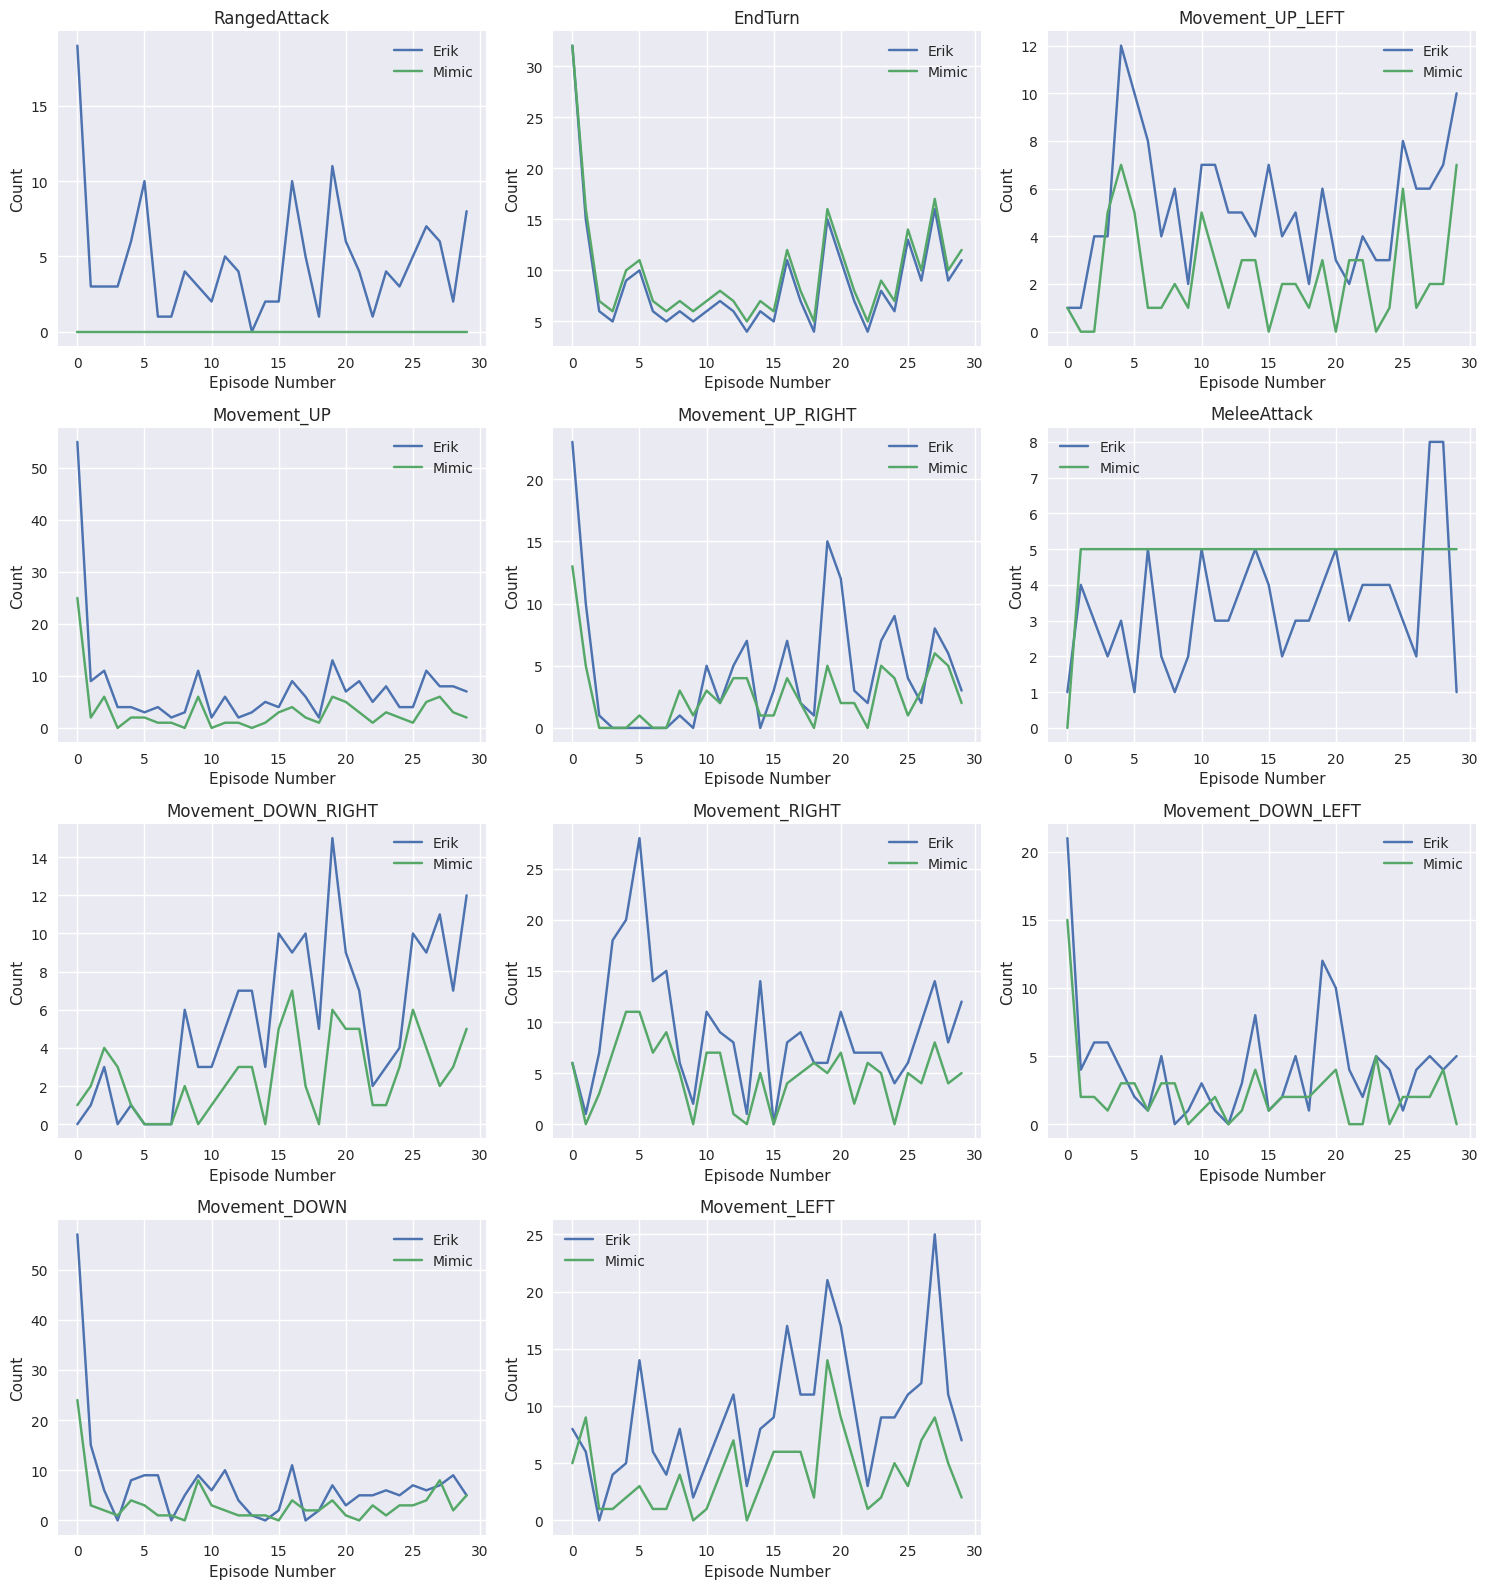

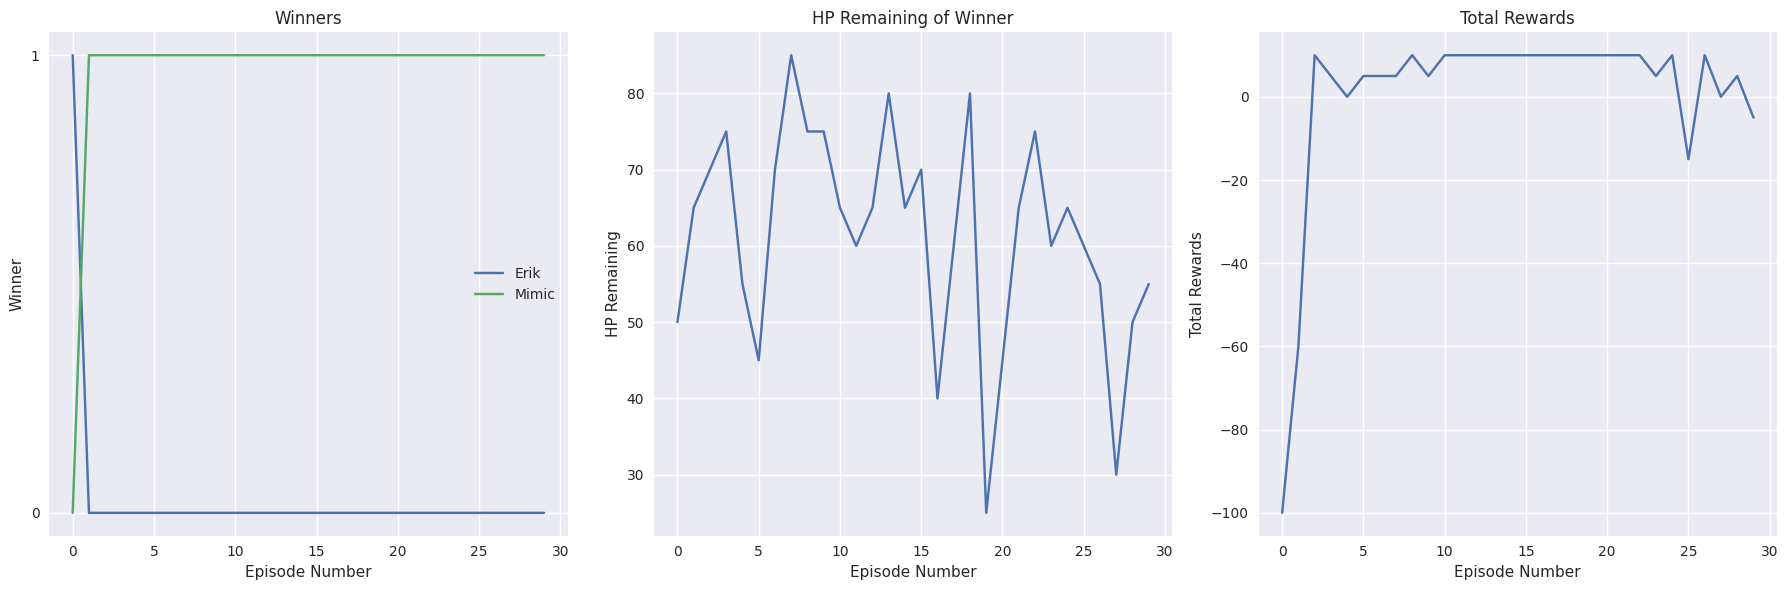

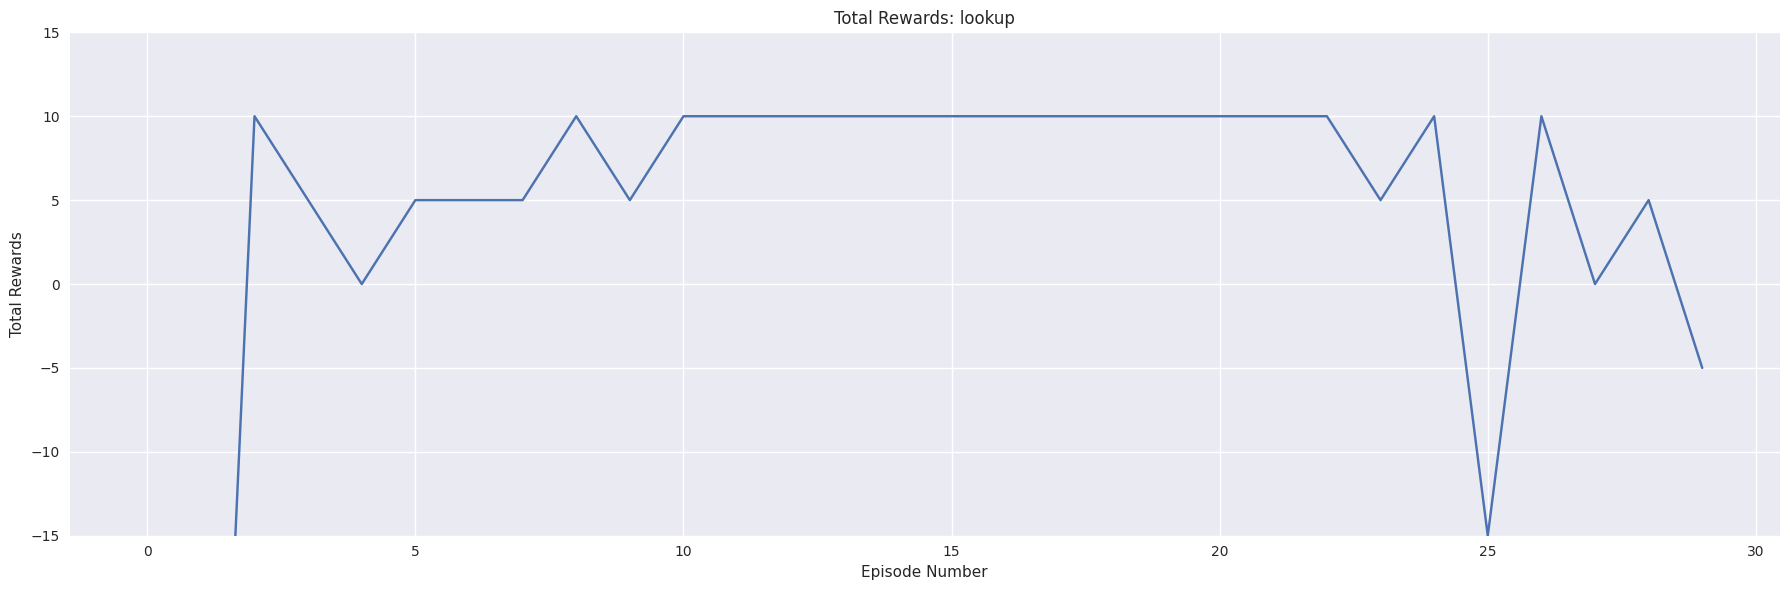

In [34]:
num_episodes = len(episode_numbers)

# Grafico per le azioni
action_names = list(actions_number[next(iter(actions_number))].keys())
num_actions = len(action_names)

# Configurazione della figura e dei subplot
fig, axs = plt.subplots(nrows=(num_actions + 2) // 3, ncols=3, figsize=(15, (num_actions + 2) // 3 * 4))

# Grafici per le azioni
for index, action_name in enumerate(action_names):
    ax = axs[index // 3, index % 3]
    for agent_name, action_counts in actions_number.items():
        ax.plot(episode_numbers, action_counts[action_name], label=agent_name)
    ax.set_title(f"{action_name}")
    ax.set_xlabel("Episode Number")
    ax.set_ylabel("Count")
    ax.legend()
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.xaxis.get_major_locator().set_params(integer=True)

# Rimuovi eventuali subplot non utilizzati
for index in range(num_actions, len(axs.flatten())):
    fig.delaxes(axs.flatten()[index])

plt.tight_layout()
plt.show()

# Prepare the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for winners
for agent_name in set(winners):
    axs[0].plot(episode_numbers, [w == agent_name for w in winners], label=agent_name)
axs[0].set_title("Winners")
axs[0].set_xlabel("Episode Number")
axs[0].set_ylabel("Winner")
axs[0].legend()
axs[0].xaxis.get_major_locator().set_params(integer=True)
axs[0].yaxis.get_major_locator().set_params(integer=True)

# Plot for HP remaining winner
axs[1].plot(episode_numbers, hp_remaining_winner, label="HP Remaining")
axs[1].set_title("HP Remaining of Winner")
axs[1].set_xlabel("Episode Number")
axs[1].set_ylabel("HP Remaining")
axs[1].xaxis.get_major_locator().set_params(integer=True)
axs[1].yaxis.get_major_locator().set_params(integer=True)

# Plot for total rewards
axs[2].plot(episode_numbers, total_rewards, label="Total Rewards")
axs[2].set_title("Total Rewards")
axs[2].set_xlabel("Episode Number")
axs[2].set_ylabel("Total Rewards")
axs[2].xaxis.get_major_locator().set_params(integer=True)
axs[2].yaxis.get_major_locator().set_params(integer=True)

plt.tight_layout()
plt.show()

# Plot for total rewards
fig, axs = plt.subplots(figsize=(18, 6))
axs.plot(episode_numbers, total_rewards, label="Total Rewards: lookup")
axs.set_title("Total Rewards: lookup")
axs.set_xlabel("Episode Number")
axs.set_ylabel("Total Rewards")
axs.set_ylim(top=15)
axs.set_ylim(bottom=-15)

# Adjust layout
plt.tight_layout()
plt.show()